# **Report**

make this nicer-looking

introduction
Structure
Example Usage + Application (vary, to showcase different scenarios)
Tests (same ones, to offer a benchmark for comparison)

## **Linear Congruential Generator**

The Linear Congruential Generator is one of the oldest ways to generate pseudorandom numbers. It's easy to understand and easy to implement, making it one of the best-known approaches to randomness in computers.

The generator is defined by the following relation:

$$X_{n+1} = (aX_n + c) \ \text{mod}\ m$$

with $X$ being the sequence of pseudo-random values, and

1. the *modulus* $m$, $m>0$
2. the *multiplier* $a$, $0<a<m$
3. the *increment* $c$, $0 \leq c < m$
4. the *seed* $X_0$, $0 \leq X_0 < m$

At every step, the formula updates the state and produces a new number. It is very fast and easy to implement; completely deterministic (same seed → same sequence), but the quality of randomness depends heavily on the choice of 𝑎, 𝑐, and 𝑚.

The main idea is that the modulo operation keeps numbers inside a fixed range, with the recurrence relation generating a sequence that "hops" around within that range. With good parameter choices, these hops approximate randomness.

The literature talks about some known limitations, but we will see these hands on when we perform some tests on the method. 
### **Multiplicative Congruential Generators**

### **Mixed Congruential Generators**

Sources:
1. https://en.wikipedia.org/wiki/Linear_congruential_generator

In [1]:
# Example Usage of the LCG Generator 

import sys
import os

# Get the absolute path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, project_root)

from prngs.lcg import LCG

# Example Parameters
modulus = 2**32
a = 1664525
c = 1013904223
seed = 42

# Initialize generator
rng = LCG(seed=seed, a=a, c=c, m=modulus)

# Generate 10 random numbers (scaled to [0,1))
for _ in range(10):
    value = LCG.next(rng)
    print(value)

0.2523451747838408
0.08812504541128874
0.5772811982315034
0.22255426598712802
0.37566019711084664
0.02566390484571457
0.4472812858875841
0.1184600037522614
0.8738137057516724
0.9946342753246427


In [2]:
# Example Application of LCG: Estimate pi using Monte Carlo Method
# Good for: Demonstrating uniformity and independence, but more in the test section.

num_samples = 10000
inside_circle = 0

for _ in range(num_samples):
    x = LCG.next(rng) 
    y = LCG.next(rng)
    if x**2 + y**2 <= 1.0:
        inside_circle += 1

pi_estimate = 4 * inside_circle / num_samples
print(pi_estimate)

3.1192


but just how good is this in more practical terms? tests

explain the tests

Running PRNG test suite...
✅ Range test passed
Mean: 0.50124, Variance: 0.08305
✅ Moments test passed
Chi-squared test p-value: 0.87531
✅ Uniformity test passed
Lag-1 autocorrelation: 0.00243
✅ Autocorrelation test passed


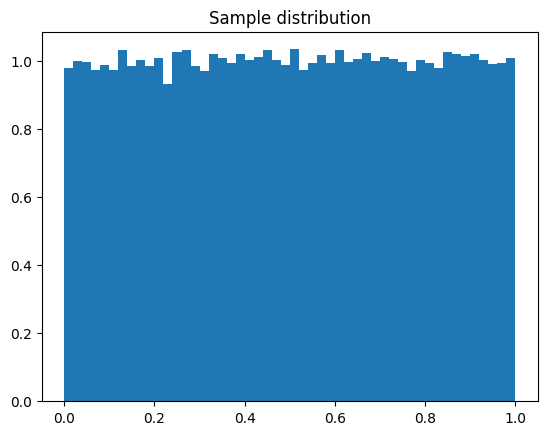

🎉 All tests passed!


In [6]:
from tests.tests import general_tests

# Run Tests
rng = LCG(seed=42, a=a, c=c, m=modulus)

general_tests(lambda: rng.next(), plot=True)

analyze results

## **Mersenne Twister**


In [ ]:
# Example Usage of MT

tests

In [ ]:
# Run Tests

## **Numpy's approach to randomness**
see what numpy does?

In [ ]:
# Show off the methods

tests

In [ ]:
# Run Tests

## **Simulations with different PRNGs**
We have seen different simulations with different PRNGs, but let's also take a look at one simulation with all of the analyzed generators -> more astro?